In [1]:
from __future__ import print_function

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using '+str(device)+"!")

Using cuda!


Load Data

In [3]:
train_dir = 'data/train/'
test_dir = 'data/test/'

In [4]:
train_list = os.listdir(train_dir)
test_list = os.listdir(test_dir)

In [5]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [6]:
for i in range(len(train_list)):
    train_list[i] = os.path.join(train_dir, train_list[i])

for i in range(len(test_list)):
    test_list[i] = os.path.join(test_dir, test_list[i])

# train_list

In [7]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
# labels

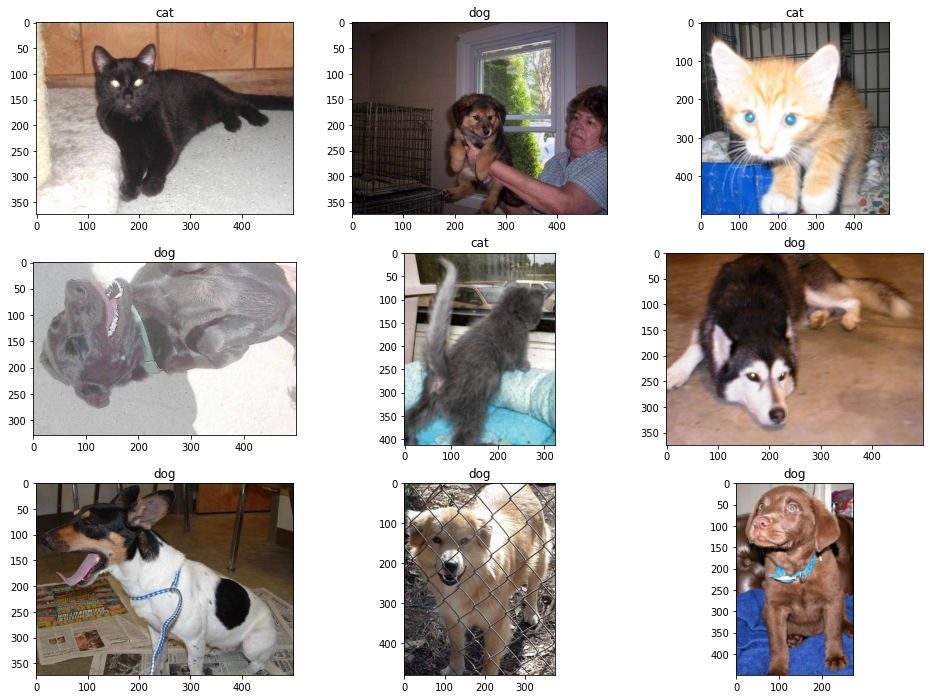

In [8]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in zip(random_idx, axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [9]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels)

In [10]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [11]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [12]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [13]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [14]:
train_loader = DataLoader(dataset = train_data, batch_size=8, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=8, shuffle=True)

In [15]:
def train(train_loader, model, loss_fn, optimizer):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = loss_fn(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    return epoch_loss, epoch_accuracy

def val(valid_loader, model, loss_fn):
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = loss_fn(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    return epoch_val_loss, epoch_val_accuracy

ViT

In [16]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [17]:
vit = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [18]:
epochs = 15
lr = 3e-5
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(vit.parameters(), lr=lr)

In [19]:
train_loss_vit = []
train_acc_vit  = []
test_loss_vit  = []
test_acc_vit   = []
for epoch in range(epochs):
    epoch_loss, epoch_accuracy = train(train_loader, vit, loss_fn, optimizer)
    epoch_val_loss, epoch_val_accuracy = val(valid_loader, vit, loss_fn)
    train_acc_vit.append(epoch_accuracy)
    train_loss_vit.append(epoch_loss)
    test_acc_vit.append(epoch_val_accuracy)
    test_loss_vit.append(epoch_val_loss)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    PATH = './target/vit/' + str(epoch) + '.pt'
    torch.save(vit.state_dict(), PATH)


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6893 - acc: 0.5364 - val_loss : 0.6633 - val_acc: 0.5954



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6642 - acc: 0.5819 - val_loss : 0.6435 - val_acc: 0.6340



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6525 - acc: 0.5981 - val_loss : 0.6323 - val_acc: 0.6322



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6415 - acc: 0.6112 - val_loss : 0.6219 - val_acc: 0.6524



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6331 - acc: 0.6278 - val_loss : 0.6153 - val_acc: 0.6602



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6296 - acc: 0.6314 - val_loss : 0.6044 - val_acc: 0.6704



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6229 - acc: 0.6423 - val_loss : 0.6042 - val_acc: 0.6726



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6174 - acc: 0.6494 - val_loss : 0.5891 - val_acc: 0.6944



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6106 - acc: 0.6593 - val_loss : 0.5838 - val_acc: 0.6988



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6045 - acc: 0.6650 - val_loss : 0.5764 - val_acc: 0.7034



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6004 - acc: 0.6738 - val_loss : 0.5779 - val_acc: 0.6984



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5923 - acc: 0.6792 - val_loss : 0.5576 - val_acc: 0.7150



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5896 - acc: 0.6826 - val_loss : 0.5587 - val_acc: 0.7152



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.5867 - acc: 0.6813 - val_loss : 0.5593 - val_acc: 0.7138



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5816 - acc: 0.6879 - val_loss : 0.5507 - val_acc: 0.7176



LeNet

In [20]:
from lenet import LeNet

In [21]:
lenet = LeNet()
lenet = lenet.to(device)

loss_fn = nn.CrossEntropyLoss()
learn_rate = 1e-2
optimzier = torch.optim.SGD(lenet.parameters(), lr=learn_rate)


In [22]:
train_loss_lenet = []
train_acc_lenet  = []
test_loss_lenet  = []
test_acc_lenet   = []
for epoch in range(epochs):
    lenet.train()
    epoch_loss, epoch_accuracy = train(train_loader, lenet, loss_fn, optimzier)
    
    lenet.eval()
    epoch_val_loss, epoch_val_accuracy = val(valid_loader, lenet, loss_fn)
    
    train_acc_lenet.append(epoch_accuracy)
    train_loss_lenet.append(epoch_loss)
    test_acc_lenet.append(epoch_val_accuracy)
    test_loss_lenet.append(epoch_val_loss)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    
    PATH = './target/lenet/' + str(epoch) + '.pt'
    torch.save(lenet.state_dict(), PATH)

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6930 - acc: 0.5070 - val_loss : 0.6887 - val_acc: 0.5554



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6871 - acc: 0.5471 - val_loss : 0.6709 - val_acc: 0.5944



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6736 - acc: 0.5837 - val_loss : 0.6655 - val_acc: 0.5896



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6615 - acc: 0.6077 - val_loss : 0.6202 - val_acc: 0.6558



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6448 - acc: 0.6310 - val_loss : 0.6136 - val_acc: 0.6558



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6349 - acc: 0.6424 - val_loss : 0.5890 - val_acc: 0.6946



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6258 - acc: 0.6508 - val_loss : 0.5798 - val_acc: 0.7048



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6148 - acc: 0.6628 - val_loss : 0.5658 - val_acc: 0.7042



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6085 - acc: 0.6649 - val_loss : 0.5649 - val_acc: 0.7080



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.5979 - acc: 0.6777 - val_loss : 0.5502 - val_acc: 0.7166



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.5941 - acc: 0.6797 - val_loss : 0.5454 - val_acc: 0.7200



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.5896 - acc: 0.6818 - val_loss : 0.5282 - val_acc: 0.7374



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5831 - acc: 0.6958 - val_loss : 0.5574 - val_acc: 0.7116



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.5770 - acc: 0.6946 - val_loss : 0.5261 - val_acc: 0.7412



  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.5729 - acc: 0.7022 - val_loss : 0.5187 - val_acc: 0.7382



stat

In [34]:
import json

data = {
    "train_loss_vit": [tensor.item() for tensor in train_loss_vit],
    "train_acc_vit": [tensor.item() for tensor in train_acc_vit],
    "test_loss_vit": [tensor.item() for tensor in test_loss_vit],
    "test_acc_vit": [tensor.item() for tensor in test_acc_vit],

    "train_loss_lenet": [tensor.item() for tensor in train_loss_lenet],
    "train_acc_lenet": [tensor.item() for tensor in train_acc_lenet],
    "test_loss_lenet": [tensor.item() for tensor in test_loss_lenet],
    "test_acc_lenet": [tensor.item() for tensor in test_acc_lenet], 
}

with open("stat.json", "w") as f:
    json.dump(data, f)

with open("stat.json", "r") as f:
    loaded_stat = json.load(f)